<h2> Install BeautifulSoup </h2>

In [1]:
#install BeautifulSoup and requests
!pip install BeautifulSoup4
!pip install requests

<h2> Scrape Wikipedia page and create Dataframe </h2>

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

#get page from wikipedia
link = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(link.text, 'lxml')

#iterate the table to get the data from the page
data = []
columns = []
table = soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    
    #First row of data is the header
    if (index == 0):
        columns = section
    else:
        data.append(section)

#convert to DataFrame
df = pd.DataFrame(data = data,columns = columns)
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


<h2> Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
</h2>

In [3]:
#Remove Boroughs that are 'Not assigned'
df = df[df['Borough'] != 'Not assigned']
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


<h2> More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
</h2>

In [4]:
# Combine multiple neighborhoods into one row separated by comma
df["Neighborhood"] = df.groupby("Postal Code")["Neighborhood"].transform(lambda neigh: ', '.join(neigh))

#remove duplicates
df = df.drop_duplicates()

#update index 
if(df.index.name != 'Postal Code'):
    df = df.set_index('Postal Code')
    
df.head()

,Borough,Neighborhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


<h2> If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
</h2>

In [5]:
# Not assigned neighborhood, then the neighborhood will be the same as the borough
df['Neighborhood'].replace("Not assigned", df["Borough"],inplace=True)
df.head()

,Borough,Neighborhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


<h2> In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.
</h2>

In [6]:
df.shape

(103, 2)

<h2> Install wget package </h2>

In [7]:
!pip install wget

<h2> Get the Geospatial Data File </h2>

In [8]:
import wget
url = 'http://cocl.us/Geospatial_data'
filename = wget.download(url)
print(filename)

100% [................................................................................] 2891 / 2891Geospatial_Coordinates (3).csv


<h2> Extract matching latitude and longitude for Postal Code </h2>

In [9]:
#Get data lat/long data from csv
lldf = pd.read_csv(filename)

#rename columns and set the index to be Postcode
lldf.columns = ["Postal Code", "Latitude", "Longitude"]
if(lldf.index.name != 'Postal Code'):
    lldf = lldf.set_index('Postal Code')
    
lldf.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


<h2> Merge DataFrames into one  </h2>

In [10]:
df = df.join(lldf)
df.head()

,Borough,Neighborhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<h2> Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data.</h2>

Install

In [11]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes 

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



<h2> Imports </h2>

In [12]:
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

<h2> Filter Canada data to only use boroughs in Toronto </h2> 

In [13]:
toronto = df[df['Borough'].str.contains('Toronto')]
toronto.head()

,Borough,Neighborhood,Latitude,Longitude
Postal Code,,,,
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
M4E,East Toronto,The Beaches,43.676357,-79.293031


<h2> Create map of Toronto </h2> 

In [15]:
# create map of Toronto using first entries latitude and longitude values
map_toronto = folium.Map(location=[toronto["Latitude"][0], toronto["Longitude"][0]], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h2> Set FourSquare Credentials </h2> 

In [16]:
CLIENT_ID = 'LFMNUAIN0PBILSX2JQKVCXNHDOQWCHJC20ENRWTD2OL5O2SG' 
CLIENT_SECRET = 'CELNFYGFD5CHN00KU5JRDGSIYBJQH025FA5B0SL3QQW4DNVT' 
VERSION = '20180605' 
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: LFMNUAIN0PBILSX2JQKVCXNHDOQWCHJC20ENRWTD2OL5O2SG
CLIENT_SECRET:CELNFYGFD5CHN00KU5JRDGSIYBJQH025FA5B0SL3QQW4DNVT


<h2> Get First Neighborhood Location</h2> 

In [17]:
neighborhood_latitude = toronto['Latitude'][0] 
neighborhood_longitude = toronto['Longitude'][0] 

neighborhood_name = toronto['Neighborhood'][0] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


<h2> Function to get Nearby Venues Data </h2> 

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h2> Get All Neighborhood </h2> 

In [20]:
LIMIT =10
venues = getNearbyVenues(names=toronto['Neighborhood'],latitudes=toronto['Latitude'],longitudes=toronto['Longitude'])
venues.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


<h2> Get counts of Venues & Unique Caegories  </h2> 

In [21]:

print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))
venues.groupby('Neighborhood').count()

There are 120 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,10,10,10,10,10,10
"Brockton, Parkdale Village, Exhibition Place",10,10,10,10,10,10
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",10,10,10,10,10,10
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",10,10,10,10,10,10
Central Bay Street,10,10,10,10,10,10
Christie,10,10,10,10,10,10
Church and Wellesley,10,10,10,10,10,10
"Commerce Court, Victoria Hotel",10,10,10,10,10,10
Davisville,10,10,10,10,10,10


<h2> Analyze the Neighborhoods </h2> 

In [22]:
# one hot encoding
toronto_encoded = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_encoded['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_encoded.columns[-1]] + list(toronto_encoded.columns[:-1])
toronto_encoded = toronto_encoded[fixed_columns]

toronto_encoded.head()


toronto_venues = toronto_encoded.groupby('Neighborhood').mean().reset_index()
toronto_venues.head(10)

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Supermarket,Sushi Restaurant,Swim School,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Vegetarian / Vegan Restaurant,Wine Bar
0,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Business reply mail Processing Centre, South C...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Christie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Church and Wellesley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0
7,"Commerce Court, Victoria Hotel",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0
8,Davisville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Davisville North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2> Viewing top 2 venues and Frequency for Neighborhoods </h2> 

In [23]:
num_top_venues = 2

for hood in toronto_venues['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_venues[toronto_venues['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
    venue  freq
0    Park   0.1
1  Museum   0.1


----Brockton, Parkdale Village, Exhibition Place----
         venue  freq
0  Coffee Shop   0.2
1       Bakery   0.1


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
         venue  freq
0  Pizza Place   0.1
1   Comic Shop   0.1


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0       Coffee Shop   0.1
1  Airport Terminal   0.1


----Central Bay Street----
         venue  freq
0  Coffee Shop   0.4
1          Spa   0.1


----Christie----
           venue  freq
0           Café   0.3
1  Grocery Store   0.2


----Church and Wellesley----
       venue  freq
0   Beer Bar   0.1
1  Bookstore   0.1


----Commerce Court, Victoria Hotel----
    venue  freq
0    Café   0.2
1  Museum   0.1


----Davisville----
          venue  freq
0  Dessert Shop   0.2
1          Park   0.1


----Davisville 

<h2> Sort the Neighborhoods by Most Common/Frequency </h2> 

In [24]:
#method to sort venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_venues['Neighborhood']

for ind in np.arange(toronto_venues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_venues.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Park,Farmers Market,Museum,Concert Hall,Liquor Store,Restaurant,Cocktail Bar,Vegetarian / Vegan Restaurant,Fountain,French Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Café,Gym,Bar,Bakery,Breakfast Spot,Italian Restaurant,Pet Store,Furniture / Home Store,Creperie
2,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Comic Shop,Restaurant,Garden Center,Skate Park,Pizza Place,Burrito Place,Farmers Market,Auto Workshop,Brewery
3,"CN Tower, King and Spadina, Railway Lands, Har...",Bar,Airport Service,Plane,Harbor / Marina,Airport Terminal,Coffee Shop,Airport Lounge,Airport Food Court,Airport,Airport Gate
4,Central Bay Street,Coffee Shop,Modern European Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Japanese Restaurant,Spa,Italian Restaurant,Diner,Comic Shop,Concert Hall


<h2> Clustering Neighborhoods </h2>

In [33]:
# set number of clusters
kclusters = int(len(toronto["Neighborhood"].unique()) / 4)
toronto_clustered = toronto_venues.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(toronto_clustered)

# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto.copy()
toronto_merged.rename(columns={'Neighborhood':'Neighborhood'}, inplace=True)
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Postal Code,,,,,,,,,,,,,,,
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Park,Gym / Fitness Center,Coffee Shop,Pub,Breakfast Spot,Restaurant,Distribution Center,Spa,Historic Site,Bakery
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8,Sushi Restaurant,Yoga Studio,Coffee Shop,Creperie,Distribution Center,Beer Bar,Italian Restaurant,Arts & Crafts Store,Park,Food & Drink Shop
M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,Café,Tea Room,Music Venue,Plaza,Pizza Place,Burrito Place,Comic Shop,Thai Restaurant,Theater,Clothing Store
M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Italian Restaurant,Cosmetics Shop,Creperie,Food Truck,Middle Eastern Restaurant,Gym,Restaurant,Japanese Restaurant,Comic Shop
M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Asian Restaurant,Pizza Place,Health Food Store,Wine Bar,Dessert Shop,Department Store,Dance Studio,Creperie


<h2> Plot Map of Clustered Neighborhoods </h2>

In [54]:
# create map
map_clusters = folium.Map(location=[toronto["Latitude"][0], toronto["Longitude"][0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

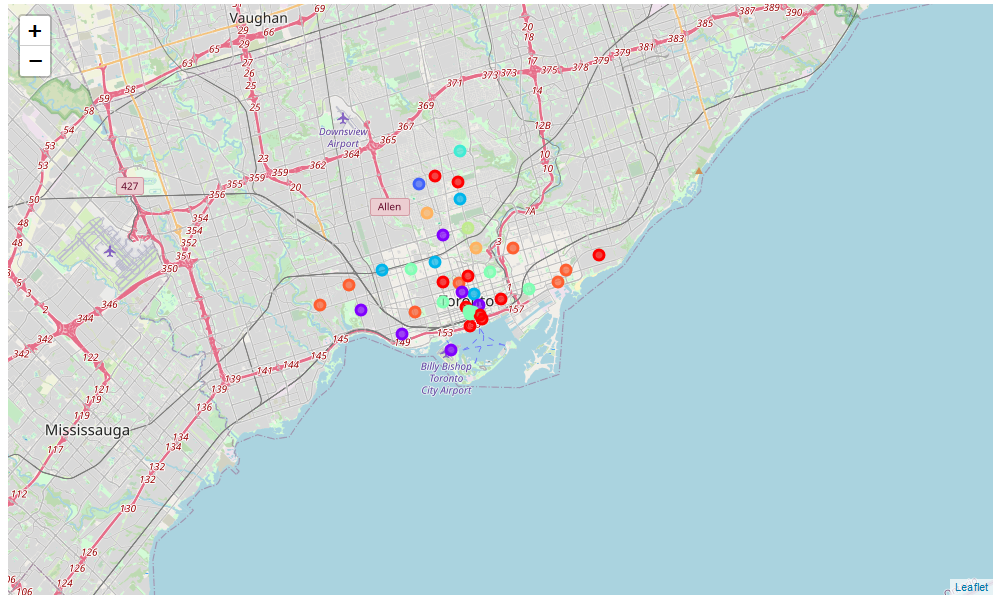

In [55]:
from IPython.display import Image
Image(filename='ClusteredMap.png') 